## Using Data Science to Develop Metrics

There have been many projects that I've done in the past couple years surrounding exploring new datasets and developing metrics. Since the data that I used in these projects is confidential, I have adapted a couple of the projects I did to use publicily data (Kaggle's [Titanic - Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview) Dataset)

The two projects I will be adapting/combining in this presentation:
1. Outlier Detection
2. Feature Importance Analysis

But in order to understand the analysis, we need the proper context around the data.
- RMS Titanic set sail on April 10th, 1912
- Heading to New York City on its maiden voyage
- Struck an iceberg on April 15th, 1912
- 1,500 out of the 2,224 passengers and crew died (~67%)

The data was sourced from Kaggle and is split into a test set and a training set

In [1]:
import pandas as pd

In [2]:
train_df = pd.read_csv('data/train.csv')
test_df = pd.read_csv('data/test.csv')
print(f"Number of passenger records in training set: {len(train_df)}")
print(f"Number of features: {len(train_df.columns) - 4}")
train_df.head()

Number of passenger records in training set: 891
Number of features: 8


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
[df['Age'].fillna(df.groupby(['Pclass','Sex'])['Age'].transform('mean'), inplace=True) for df in [train_df, test_df]]

[None, None]

According to the documentation, 
- *survived: Target (0 = No, 1 = Yes)*
- pclass: Ticket  class (1 = 1st, 2 = 2nd, 3 = 3rd)
- sibsp: # of siblings / spouses aboard the Titanic
- parch: # of parents / children aboard the Titanic
- ticket: Ticket number
- fare: Passenger fare
- cabin: Cabin number
- embarked:	Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton)

### Part 1: Outlier Detection

The team that I was working with was in charge of the software and content for any information a customer service representative might need to handle a member or provider's inquiry. The team wanted to identify specific days, based on the caller's reaction to the call (VOC Survey), in order to perform a case study to see if anything could be learned from those days. 

Instead of trying to fit a function to this data (which was multi-dimensional and very clearly non-linear) and find outliers using the distance of various points from that function, I found an algorithm called the [Extended Isolation Forest](https://ieeexplore.ieee.org/document/8888179), which is an improvement on the [Isolation Forest](https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf), that can find outliers in n-dimensional data in a model agnostic way. It is essentially an unsupervised machine learning model used specifically to identify anamolies in data. This script is a modified version of what I developed for that project.

My intuition is that there is something that can be extracted from either the ticket number or the name that would give us more information about the passenger, which could help us identify another feature to help the model later on. Using the algorithm to find the outliers that survived and shouldn't have to see if we can identify any patterns in the ticket number or their names.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import eif as iso
import seaborn as sb
sb.set_style(style="whitegrid")
sb.set_color_codes()

In [5]:
train_df['Is_Female'] = np.where(train_df['Sex'] == 'female', 1, 0)
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Is_Female'],
      dtype='object')

In [6]:
survived_df, ns_df = train_df[train_df.Survived == 1], train_df[train_df.Survived == 0]
print(len(survived_df), len(ns_df))

342 549


In [7]:
X_survived = np.array([survived_df.Pclass, survived_df.Age, survived_df.SibSp,
                       survived_df.Parch, survived_df.Is_Female]).T
X_ns = np.array([ns_df.Pclass, ns_df.Age, ns_df.SibSp, ns_df.Parch, ns_df.Is_Female]).T

len(X_survived.T)

5

In [8]:
F0 = iso.iForest(X_survived, ntrees=100, sample_size=len(survived_df), ExtensionLevel=4)
F1 = iso.iForest(X_ns, ntrees=100, sample_size=len(ns_df), ExtensionLevel=4)

S0 = F0.compute_paths(X_in=X_survived)
S1 = F1.compute_paths(X_in=X_ns)

In [9]:
ss0, ss1 = np.argsort(S0), np.argsort(S1)

In [10]:
survived_df.iloc[ss0[-20:]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_Female
237,238,1,2,"Collyer, Miss. Marjorie ""Lottie""",female,8.00,0,2,C.A. 31921,26.2500,NaN,S,1
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C,0
268,269,1,1,"Graham, Mrs. William Thompson (Edith Junkins)",female,58.00,0,1,PC 17582,153.4625,C125,S,1
448,449,1,3,"Baclini, Miss. Marie Catherine",female,5.00,2,1,2666,19.2583,NaN,C,1
788,789,1,3,"Dean, Master. Bertram Vere",male,1.00,1,2,C.A. 2315,20.5750,NaN,S,0
802,803,1,1,"Carter, Master. William Thornton II",male,11.00,1,2,113760,120.0000,B96 B98,S,0
445,446,1,1,"Dodge, Master. Washington",male,4.00,0,2,33638,81.8583,A34,S,0
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,0
366,367,1,1,"Warren, Mrs. Frank Manley (Anna Sophia Atkinson)",female,60.00,1,0,110813,75.2500,D37,C,1
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.00,0,0,113572,80.0000,B28,NaN,1


In [11]:
ns_df.iloc[ss1[-20:]]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Is_Female
456,457,0,1,"Millet, Mr. Francis Davis",male,65.0,0,0,13509,26.5500,E38,S,0
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,1
642,643,0,3,"Skoog, Miss. Margit Elizabeth",female,2.0,3,2,347088,27.9000,NaN,S,1
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,1
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.0,0,1,113509,61.9792,B30,C,0
419,420,0,3,"Van Impe, Miss. Catharina",female,10.0,0,2,345773,24.1500,NaN,S,1
731,732,0,3,"Hassan, Mr. Houssein G N",male,11.0,0,0,2699,18.7875,NaN,C,0
326,327,0,3,"Nysveen, Mr. Johan Hansen",male,61.0,0,0,345364,6.2375,NaN,S,0
33,34,0,2,"Wheadon, Mr. Edward H",male,66.0,0,0,C.A. 24579,10.5000,NaN,S,0
164,165,0,3,"Panula, Master. Eino Viljami",male,1.0,4,1,3101295,39.6875,NaN,S,0


Looking at the outliers, there are a few things that jump out:


Let's extract the title of each passenger and the number of cabins they had and use those as features.

In [12]:
train_df['Title'], test_df['Title'] = [df.Name.str.extract \
        (' ([A-Za-z]+)\.', expand=False) for df in [train_df, test_df]]

In [13]:
train_df['Num_Cabins'], test_df['Num_Cabins'] = \
    [df['Cabin'].map(lambda x: len(x.split(' ')) if type(x) != float else 0) for df in [train_df, test_df]]


In [14]:
max(train_df.Num_Cabins)

4

### Finding Important Features

This project was originally meant to identify what aspects of the call have an effect on the member's perception of Agent Knowledge. In the past, when they initially started looking at call transcripts and recordings, they noticed that when the agent's mispronounced or stumbled on the pronouncation of prescription drugs, the members where likely to score the Agent's Knowlege lower. There had been multiple initatives like this, and a lot of the more obvious, low hanging fruit had been fixed. 

For this project, the business was looking to find other call types or features in the data that had an effect on Agent Knowledge, as they were looking to make it a primary metric to focus on.

I added Agent Training data to the calls data to get the features, with the Agent Knowledge as the target

In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [16]:
cat_columns = ['Pclass', 'Sex', 'Embarked', 'Title']
num_columns = ['Age', 'SibSp', 'Parch', 'Fare', 'Num_Cabins']
               
y = train_df.Survived

In [17]:
train_df['Embarked'].fillna('NA', inplace=True)
X = train_df[cat_columns + num_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_encoder = OneHotEncoder(handle_unknown='ignore')
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_encoder, cat_columns),
     ('num', numerical_pipe, num_columns)])



In [22]:
rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

ab = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', AdaBoostClassifier(random_state=42))
])
ab.fit(X_train, y_train)
               
dt = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', DecisionTreeClassifier(random_state=42))
])
dt.fit(X_train, y_train)

lg = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', LogisticRegression(random_state=42))
])
lg.fit(X_train, y_train)

/Users/arnav/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Pclass', 'Sex', 'Embarked',
                                                   'Title']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare', 'Num_Cabins'])])),
                ('classifier', LogisticRegression(random_state=42))])

In [23]:
print(f'RF train accuracy: {rf.score(X_train,y_train)}')
print(f'RF test accuracy: {rf.score(X_test, y_test)}')
print(f'AB train accuracy: {ab.score(X_train,y_train)}')
print(f'AB test accuracy: {ab.score(X_test, y_test)}')
print(f'DT train accuracy: {dt.score(X_train,y_train)}')
print(f'DT test accuracy: {dt.score(X_test, y_test)}')
print(f'LG train accuracy: {lg.score(X_train,y_train)}')
print(f'LG test accuracy: {lg.score(X_test, y_test)}')

RF train accuracy: 0.9865269461077845
RF test accuracy: 0.7757847533632287
AB train accuracy: 0.8607784431137725
AB test accuracy: 0.7757847533632287
DT train accuracy: 0.9865269461077845
DT test accuracy: 0.7354260089686099
LG train accuracy: 0.8383233532934131
LG test accuracy: 0.8161434977578476


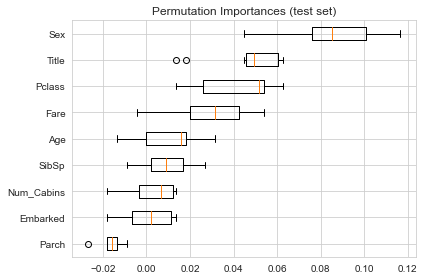

In [24]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

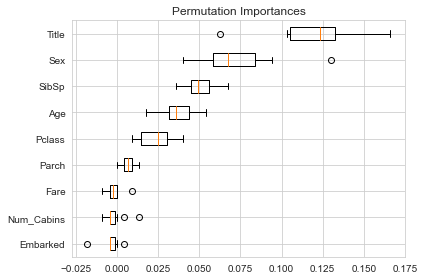

In [25]:
result = permutation_importance(lg, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances")
fig.tight_layout()
plt.show()

In [26]:
train_df.groupby(['Pclass'])['Fare'].transform('mean')
# 13.67 -> ~370
# 20.66 -> ~550
# 84.15 -> ~2,300

0      13.675550
1      84.154687
2      13.675550
3      84.154687
4      13.675550
         ...    
886    20.662183
887    84.154687
888    13.675550
889    84.154687
890    13.675550
Name: Fare, Length: 891, dtype: float64

In [55]:
def prediction(sample):
    if lg.predict(sample)[0] == 1:
        print('Survived!')

    else:
        print("Rose wouldn't scoot over")

In [58]:
sample = train_df.sample(n=1)
sample['Sex'] = 'male'
sample['Age'] = 24
sample['Pclass'] = 3
sample['Title'] = 'Master'
sample['SibSp'] = 0
sample['Parch'] = 0
if sample['Pclass'] == 3:
    sample['Fare'] = 13.67
    sample['Num_Cabins'] = 0
elif sample['Pclass'] == 2:
    sample['Fare'] = 20.66
    sample['Num_Cabins'] = 0
else:
    sample['Fare'] = 84.15
    sample['Num_Cabins'] = 1


In [59]:
prediction(sample)

Survived!


/Users/arnav/opt/anaconda3/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


In [39]:
sample.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Is_Female', 'Title',
       'Num_Cabins'],
      dtype='object')